# Train  a new classifier for ISSM-CoastSat

In this notebook the ISSM-CoastSat classifier is trained using satellite images from new sites. This can improve the accuracy of the shoreline detection if the users are experiencing issues with the default classifier.

#### Initial settings

In [1]:
# load modules
%load_ext autoreload
%autoreload 2
%matplotlib inline
import os, sys
import numpy as np
import pickle
import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

# sklearn modules
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import cross_val_score
import sklearn
if sklearn.__version__[:4] == '0.20':
    from sklearn.externals import joblib
else:
    import joblib

# coastsat modules
sys.path.insert(0, os.pardir)
from coastsat import SDS_download, SDS_preprocess, SDS_shoreline, SDS_tools, SDS_classify

# plotting params
plt.rcParams['font.size'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams['axes.titlesize'] = 12
plt.rcParams['axes.labelsize'] = 12

# filepaths 
filepath_images = os.path.join(os.getcwd(), 'data')
filepath_train = os.path.join(os.getcwd(), 'training_data')
filepath_models = os.path.join(os.getcwd(), 'models')

# settings
settings ={'filepath_train':filepath_train, # folder where the labelled images will be stored
           'inputs':{'filepath':filepath_images}, # folder where the images are stored
           'labels':{'sand':1,'white-water':2,'water':3,'other land features':4}, # labels for the classifier
           'colors':{'sand':[1, 0.65, 0],'white-water':[1,0,1],'water':[0.1,0.1,0.7],'other land features':[0.8,0.8,0.1]},
           'tolerance':0.05, # this is the pixel intensity tolerance, when using flood fill for sandy pixels
                             # set to 0 to select one pixel at a time
           # general parameters:
           'cloud_thresh': 0.9,        # threshold on maximum cloud cover
           'dist_clouds': 300,         # ditance around clouds where shoreline can't be mapped
           'output_epsg': 4326,       # epsg code of spatial reference system desired for the output
           # quality control:
           'check_detection': True,    # if True, shows each shoreline detection to the user for validation
           'adjust_detection': False,  # if True, allows user to adjust the postion of each shoreline by changing the threhold
           'save_figure': True,        # if True, saves a figure showing the mapped shoreline for each image
           # [ONLY FOR ADVANCED USERS] shoreline detection parameters:
           'min_beach_area': 1000,     # minimum area (in metres^2) for an object to be labelled as a beach
           'min_length_sl': 500,       # minimum length (in metres) of shoreline perimeter to be valid
           'cloud_mask_issue': True,  # switch this parameter to True if sand pixels are masked (in black) on many images  
           'sand_color': 'default',    # 'default', 'latest', 'dark' (for grey/black sand beaches) or 'bright' (for white sand beaches)
           'pan_off': False,           # True to switch pansharpening off for Landsat 7/8/9 imagery           
            }
        
# read kml files for the training sites
filepath_sites = os.path.join(os.getcwd(), 'training_sites')
train_sites = os.listdir(filepath_sites)
print('Sites for training:\n%s\n'%train_sites)

Sites for training:
['BYRON.kml', 'NEWCASTLE.kml', 'SAWTELL.kml']



### 1. Download images

For each site on which you want to train the classifier, save a .shp file with the region of interest (5 vertices clockwise, first and last points are the same, can be created from QGIS) in the folder *\training_sites*.

You only need a few images (~10) to train the classifier, but can add more if using more complex models.

In [4]:
# dowload images at the sites
dates = ['2019-01-01', '2019-07-01']
# satellite missions ['L5','L7','L8','L9','S2']
sat_list = ['L8']
# choose Landsat collection 'C01' or 'C02'
collection = 'C02'
input_list = {}
for site in train_sites:
    polygon = SDS_tools.polygon_from_kml(os.path.join(filepath_sites,site))
    polygon = SDS_tools.smallest_rectangle(polygon)
    sitename = site[:site.find('.')]  
    inputs = {'polygon':polygon, 'dates':dates, 'sat_list':sat_list,
             'sitename':sitename, 'filepath':filepath_images,
             'landsat_collection': collection}
    input_list[sitename] = inputs
    print(sitename)
    #metadata = SDS_download.retrieve_images(inputs)

BYRON
NEWCASTLE
SAWTELL


### 2. Label images

Label the images into 4 classes: sand, white-water, water and other land features.

The labelled images are saved in the *filepath_train* and can be visualised afterwards for quality control. If you make a mistake, don't worry, this can be fixed later by deleting the labelled image.

In [5]:
# label the images with an interactive annotator
%matplotlib qt
master_settings=settings
for site in train_sites:
    # load metadata
    sitename = site[:site.find('.')] 
    site_inputs = input_list[sitename]
    settings['inputs'] = site_inputs
    metadata = SDS_download.get_metadata(settings['inputs'])
    # label images
    SDS_classify.label_images(metadata,settings)

StopIteration: User cancelled labelling images

### 3. Train Classifier

A Multilayer Perceptron is trained with *scikit-learn*. To train the classifier, the training data needs to be loaded.

You can use the data that was labelled here and/or the original CoastSat training data.

In [6]:
# load labelled images
features = SDS_classify.load_labels(train_sites, settings)

Number of pixels per class in training data:
sand : 857 pixels
white-water : 29 pixels
water : 10544 pixels
other land features : 16230 pixels


In [7]:
# you can also load the original CoastSat training data (and optionally merge it with your labelled data)
with open(os.path.join(settings['filepath_train'], 'CoastSat_training_set_L8.pkl'), 'rb') as f:
    features_original = pickle.load(f)
for key in features_original.keys():
    print('%s : %d pixels'%(key,len(features_original[key])))

sand : 7009 pixels
water : 18513 pixels
white-water : 752 pixels
other land features : 29399 pixels


Run this section to combine the original training data with your labelled data:

In [11]:
# add the white-water data from the original training data
features['white-water'] = np.append(features['white-water'], features_original['white-water'], axis=0)
# or merge all the classes
for key in features.keys():
    features[key] = np.append(features[key], features_original[key], axis=0)
features = features_original 
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

sand : 7009 pixels
water : 18513 pixels
white-water : 752 pixels
other land features : 29399 pixels


[OPTIONAL] As the classes do not have the same number of pixels, it is good practice to subsample the very large classes (in this case 'water' and 'other land features'):

In [12]:
# subsample randomly the land and water classes
# as the most important class is 'sand', the number of samples should be close to the number of sand pixels
n_samples = 5000
for key in ['water', 'other land features']:
    features[key] =  features[key][np.random.choice(features[key].shape[0], n_samples, replace=False),:]
# print classes again
for key in features.keys():
    print('%s : %d pixels'%(key,len(features[key])))

sand : 7009 pixels
water : 5000 pixels
white-water : 752 pixels
other land features : 5000 pixels


When the labelled data is ready, format it into X, a matrix of features, and y, a vector of labels:

In [13]:
# format into X (features) and y (labels) 
classes = ['sand','white-water','water','other land features']
labels = [1,2,3,0]
X,y = SDS_classify.format_training_data(features, classes, labels)

Divide the dataset into train and test: train on 70% of the data and evaluate on the other 30%:

In [14]:
# divide in train and test and evaluate the classifier
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, shuffle=True, random_state=0)
classifier = MLPClassifier(hidden_layer_sizes=(100,50), solver='adam')
classifier.fit(X_train,y_train)
print('Accuracy: %0.4f' % classifier.score(X_test,y_test))

Accuracy: 0.9987


[OPTIONAL] A more robust evaluation is 10-fold cross-validation (may take a few minutes to run):

In [ ]:
# cross-validation
scores = cross_val_score(classifier, X, y, cv=10)
print('Accuracy: %0.4f (+/- %0.4f)' % (scores.mean(), scores.std() * 2))

Plot a confusion matrix:

Confusion matrix, without normalization


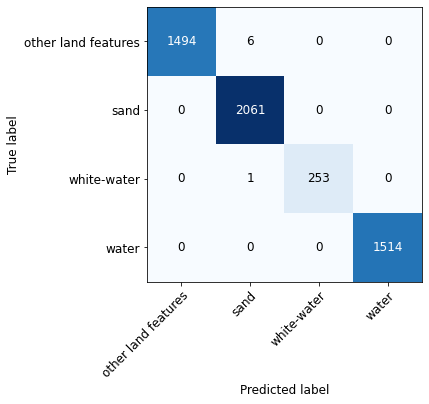

In [15]:
# plot confusion matrix
%matplotlib inline
y_pred = classifier.predict(X_test)
SDS_classify.plot_confusion_matrix(y_test, y_pred,
                                   classes=['other land features','sand','white-water','water'],
                                   normalize=False);

When satisfied with the accuracy and confusion matrix, train the model using ALL the training data and save it:

In [ ]:
# train with all the data and save the final classifier
classifier = MLPClassifier(hidden_layer_sizes=(100,50), solver='adam')
classifier.fit(X,y)
joblib.dump(classifier, os.path.join(filepath_models, 'NN_4classes_Landsat_test.pkl'))

### 4. Evaluate the classifier

Load a classifier that you have trained (specify the classifiers filename) and evaluate it on the satellite images.

This section will save the output of the classification for each site in a directory named \evaluation.

In [ ]:
# load and evaluate a classifier
%matplotlib qt
classifier = joblib.load(os.path.join(filepath_models, 'NN_4classes_Landsat_test.pkl'))
settings['output_epsg'] = 3857
settings['min_beach_area'] = 4500
settings['buffer_size'] = 200
settings['min_length_sl'] = 200
settings['cloud_thresh'] = 0.5
# visualise the classified images
for site in train_sites:
    settings['inputs']['sitename'] = site[:site.find('.')] 
    # load metadata
    metadata = SDS_download.get_metadata(settings['inputs'])
    # plot the classified images
    SDS_classify.evaluate_classifier(classifier,metadata,settings)